In [29]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





# clustering choice 


In [30]:
user=pd.read_csv("C:/Users/chenl/Data Science prep/data/cc_info - Credit Card Transactions.csv")
transactions=pd.read_csv("C:/Users/chenl/Data Science prep/data/transactions - Credit Card Transactions.csv",parse_dates=["date"])
transactions["month"]=transactions["date"].dt.month
transactions["day"]=transactions["date"].dt.day

In [31]:
user.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [32]:
transactions.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,month,day
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,9,11
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,10,24
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,10,26
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,10,22
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,10,26


In [33]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   date                       294588 non-null  datetime64[ns]
 2   transaction_dollar_amount  294588 non-null  float64       
 3   Long                       294588 non-null  float64       
 4   Lat                        294588 non-null  float64       
 5   month                      294588 non-null  int32         
 6   day                        294588 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(2), int64(1)
memory usage: 13.5 MB


In [34]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB


# 1
identify those users that in your dataset never went above the 
monthly credit card limitc�alendarmonth�. The goal of this is to automaticall  increas 
their limitim the list of Ids?

In [35]:
# groupby credit_card, month, sum the transaction_dollar_amount, then merge with the user table 
# merge to get the limit
balance=pd.merge(transactions[["credit_card","month","day","transaction_dollar_amount"]],user[["credit_card","credit_card_limit"]],how="left",on="credit_card")
balance.sort_values(["credit_card","month","day"],inplace=True)
# create cumulative amunt column
balance["cumulative"]=balance.groupby(["credit_card","month"])["transaction_dollar_amount"].cumsum()
# balance.head(30)
# create new whether overdraw
balance["overdraw"] = balance.apply( lambda x: 1 if x["credit_card_limit"] < x["cumulative"] else 0,axis=1)
balance

,credit_card,month,day,transaction_dollar_amount,credit_card_limit,cumulative,overdraw
38,1003715054175576,7,31,45.52,20000,45.52,0
107,1003715054175576,7,31,20.94,20000,66.46,0
194,1003715054175576,7,31,96.10,20000,162.56,0
80,1003715054175576,8,1,96.97,20000,96.97,0
103,1003715054175576,8,1,97.35,20000,194.32,0
...,...,...,...,...,...,...,...
294582,9999757432802760,10,23,216.30,6000,6110.93,1
294503,9999757432802760,10,24,233.97,6000,6344.90,1
294508,9999757432802760,10,25,177.51,6000,6522.41,1
294519,9999757432802760,10,27,146.37,6000,6668.78,1


In [36]:
# aggregation to include user with max overdraw column
good_user=balance.groupby("credit_card")["overdraw"].max().reset_index()
#
good_user=good_user[good_user["overdraw"]==0]
good_user
# only 862 haven't overdraw during the period

,credit_card,overdraw
0,1003715054175576,0
1,1013870087888817,0
2,1023820165155391,0
3,1073931538936472,0
4,1077622576192810,0
...,...,...
978,9946917923319410,0
979,9958678964376192,0
980,9961694231875562,0
981,9981251982982618,0


# 2
implement an algorithm that as soon as a user goes above the limit, triggers an alert so that the user can be notified about that. (return a list of user exceed limit, do it per day, if list no empty?)

In [37]:
# groupby each user, sort the date and add a cummulative column for total spending
# define function, return the user_id of those pass the limit at the day
def alert(data,month,day):
    
    # # locate month and day range, then groupby to get the limit and transaction dollar amount, this step can be simpler if we use the balance DF from last question
    # target=data[(data["month"]==month) & (data["day"]<=day)] 
    # limit = data.groupby('credit_card')['credit_card_limit'].min().reset_index()
    # transaction = data.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    
    target=data[(data["month"]==month) & (data["day"]<=day)] # simpler if use last question DF balance, including days before the target date
    result=target[target["cumulative"]>target["credit_card_limit"]] # filter for all days that cumulative past
    # result=result.groupby("credit_card")["cumulative"].last().reset_index() # then, use the last row of the credit_card
    result=result.groupby("credit_card").apply(lambda x: x.iloc[-1]).reset_index(drop=True) #
    return result
alert(balance,month=8,day=20)

,credit_card,month,day,transaction_dollar_amount,credit_card_limit,cumulative,overdraw
0,2.850147e+15,8.0,16.0,17.31,4000.0,4012.81,1.0
1,3.936887e+15,8.0,20.0,54.61,4000.0,5352.07,1.0
2,4.118286e+15,8.0,20.0,58.03,3000.0,3416.52,1.0
3,4.462291e+15,8.0,20.0,86.69,2000.0,3119.53,1.0
4,5.723636e+15,8.0,20.0,106.89,2000.0,2161.30,1.0
5,7.299184e+15,8.0,20.0,118.27,7000.0,7074.49,1.0
6,7.850943e+15,8.0,20.0,32.98,4000.0,5704.00,1.0
7,8.522876e+15,8.0,20.0,24.99,5000.0,5860.89,1.0
8,8.972201e+15,8.0,20.0,48.10,5000.0,5266.08,1.0


# 3
concerned about frauds cause they are a huge cost for credit 
card companies. She wants you to implement an unsupervised algorithm that returns al 
transactions that seem unusual and are worth being investigated furthe (it's transaction focus?)r.

DBSCAN: Groups data into dense regions and marks low-density points as anomalies.

        Identify core points: Points with at least min_samples neighbors within distance eps.
        Expand clusters: Connect core points and their neighbors to form clusters.
        Mark outliers: Points that cannot be reached from any cluster are classified as noise.

One-Class SVM: Trains a model on normal data and flags anomalies as points outside the learned boundary.


        Train the model on "normal" data (typically unsupervised with only one class).
        Map the data into a higher-dimensional space using a kernel function (e.g., linear, RBF).
        Learn a hyperplane that encloses the majority of the data points with a margin.
        Points outside the boundary are flagged as anomalies.


Isolation Forest: anomaly detection by isolating rare data points. ensemble method, key idea is to isolate anomalies by recursively splitting the data.


        Build multiple random decision trees by randomly selecting features and splitting points.
        For each point, measure the path length (the number of splits required to isolate the point).
        Points with shorter path lengths are classified as anomalies.



For Anomaly Detection (Primary Goal):

Start with Isolation Forest or One-Class SVM.
These methods are specifically designed for detecting rare anomalies.


For Supporting Insights:

Use PCA for preprocessing and noise reduction.
Apply DBSCAN if clusters are expected, and look at noise points as potential anomalies.


For Exploration or Visualization:

Use t-SNE or LLE to visualize transaction patterns and identify areas with sparse data points.

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

# premodel data processing
it's transaction focus: extract meaningful information through feature engineer, for particualr transaction not user
- turn madian of LONG+LAT (mostly consumption location), then get the distance from each transaction,  
- monthly mean=month transaction total/transaction count
- cumulative transaction away % from limit for the motnh
- merge card user's profile (ideally if possible, get the transaction geographic distance)


In [39]:
# location/distance
long_median = transactions.groupby("credit_card")["Long"].median()
lat_median = transactions.groupby("credit_card")["Lat"].median()
transactions["Long_median"] = transactions["credit_card"].map(long_median)
transactions["Lat_median"] = transactions["credit_card"].map(lat_median)
# Euclidean distance
distance_to_median = np.sqrt(
    (transactions["Long_median"] - transactions["Long"])**2 +
    (transactions["Lat_median"] - transactions["Lat"])**2
)
transactions["distance_to_median"] = distance_to_median

In [40]:
# monthly mean
month_mean=transactions.groupby(["credit_card","month"])["transaction_dollar_amount"].mean().reset_index()
transactions=pd.merge(transactions,month_mean.rename(columns={"transaction_dollar_amount": "month_mean"}),how="left",on=["credit_card", "month"])
transactions["diff_to_mean"]=transactions["transaction_dollar_amount"]-transactions["month_mean"]

In [41]:
# cumulative transaction away from limit in %
transactions.sort_values(["credit_card","month","day"],inplace=True)
transactions["cumulative_balance"]=transactions.groupby(["credit_card","month"])["transaction_dollar_amount"].cumsum()

#merge user profile
transactions=pd.merge(transactions,user,how="left",on="credit_card")
transactions["%_to_limit"]=(transactions["credit_card_limit"]-transactions["cumulative_balance"])/transactions["credit_card_limit"]*100

In [42]:
# select useful columns
final=transactions[["credit_card","transaction_dollar_amount","month","day","distance_to_median","Long","Lat","month_mean","diff_to_mean",
                          "cumulative_balance","zipcode","state","%_to_limit"]]

In [43]:
final.head()

,credit_card,transaction_dollar_amount,month,day,distance_to_median,Long,Lat,month_mean,diff_to_mean,cumulative_balance,zipcode,state,%_to_limit
0,1003715054175576,45.52,7,31,0.078268,-80.186336,40.168399,54.186667,-8.666667,45.52,15342,PA,99.77240
1,1003715054175576,20.94,7,31,0.051939,-80.262219,40.242532,54.186667,-33.246667,66.46,15342,PA,99.66770
2,1003715054175576,96.10,7,31,0.057728,-80.156132,40.222907,54.186667,41.913333,162.56,15342,PA,99.18720
3,1003715054175576,96.97,8,1,0.078601,-80.144866,40.286490,98.157093,-1.187093,96.97,15342,PA,99.51515
4,1003715054175576,97.35,8,1,0.061144,-80.163659,40.203355,98.157093,-0.807093,194.32,15342,PA,99.02840


# anomalies detection, Isolation Forest

In [44]:
# focus on anomaly detertion features
features=final[["transaction_dollar_amount","month","distance_to_median","diff_to_mean",
                          "cumulative_balance","%_to_limit"]]
features.info()
# no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   transaction_dollar_amount  294588 non-null  float64
 1   month                      294588 non-null  int32  
 2   distance_to_median         294588 non-null  float64
 3   diff_to_mean               294588 non-null  float64
 4   cumulative_balance         294588 non-null  float64
 5   %_to_limit                 294588 non-null  float64
dtypes: float64(5), int32(1)
memory usage: 12.4 MB


In [45]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
features_scaled=scaler.fit_transform(features)

In [46]:
from sklearn.ensemble import IsolationForest
isolation_forest=IsolationForest(n_estimators=100,contamination=0.05,random_state=100)
# n_estimators= Number of trees,more trees improve accuracy but increase computational cost
# contamination: Proportion of anomalies expected in the dataset (e.g., 0.05 for 5%).
isolation_forest.fit(features)
final["tree_anomaly_if"]=isolation_forest.predict(features) # prediction

In [47]:
tree_anomaly=final[final["tree_anomaly_if"]==-1] # -1 for anomaly, 0 for no
tree_anomaly

,credit_card,transaction_dollar_amount,month,day,distance_to_median,Long,Lat,month_mean,diff_to_mean,cumulative_balance,zipcode,state,%_to_limit,tree_anomaly_if
2,1003715054175576,96.10,7,31,0.057728,-80.156132,40.222907,54.186667,41.913333,162.56,15342,PA,99.187200,-1
70,1003715054175576,859.31,8,24,0.022636,-80.202474,40.221667,98.157093,761.152907,6830.06,15342,PA,65.849700,-1
93,1003715054175576,905.54,9,2,0.054976,-80.237126,40.290891,129.673103,775.866897,1365.54,15342,PA,93.172300,-1
108,1003715054175576,99.27,9,8,115.693816,34.429275,24.659874,129.673103,-30.403103,3216.21,15342,PA,83.918950,-1
118,1003715054175576,995.35,9,11,0.085291,-80.126760,40.225626,129.673103,865.676897,4923.71,15342,PA,75.381450,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294543,9999757432802760,827.32,9,29,0.065155,-82.369723,33.062696,154.880000,672.440000,6669.60,30434,GA,-11.160000,-1
294557,9999757432802760,342.92,10,9,0.068600,-82.413146,33.047057,159.628605,183.291395,1737.76,30434,GA,71.037333,-1
294567,9999757432802760,896.09,10,15,0.059609,-82.363676,33.057257,159.628605,736.461395,3675.94,30434,GA,38.734333,-1
294584,9999757432802760,233.97,10,24,0.077597,-82.410848,32.934690,159.628605,74.341395,6344.90,30434,GA,-5.748333,-1


# anomalies detection, one class SVM
- useful to sacle

In [48]:
from sklearn.svm import OneClassSVM

svm=OneClassSVM(kernel="rbf",gamma=0.01,nu=0.05)
svm.fit(features_scaled) # ideal, should scaled for normal pipeline
# kernel: Specifies the kernel type (e.g., "rbf" for non-linear relationships).
# gamma: Defines the influence of each data point in the decision boundary.
# nu: Controls the proportion of support vectors and expected outliers.

svm.fit(features_scaled)
final["is_anomaly_svm"] = svm.predict(features_scaled)
final[final["is_anomaly_svm"]==-1]

,credit_card,transaction_dollar_amount,month,day,distance_to_median,Long,Lat,month_mean,diff_to_mean,cumulative_balance,zipcode,state,%_to_limit,tree_anomaly_if,is_anomaly_svm
0,1003715054175576,45.52,7,31,0.078268,-80.186336,40.168399,54.186667,-8.666667,45.52,15342,PA,99.772400,1,-1
1,1003715054175576,20.94,7,31,0.051939,-80.262219,40.242532,54.186667,-33.246667,66.46,15342,PA,99.667700,1,-1
70,1003715054175576,859.31,8,24,0.022636,-80.202474,40.221667,98.157093,761.152907,6830.06,15342,PA,65.849700,-1,-1
93,1003715054175576,905.54,9,2,0.054976,-80.237126,40.290891,129.673103,775.866897,1365.54,15342,PA,93.172300,-1,-1
108,1003715054175576,99.27,9,8,115.693816,34.429275,24.659874,129.673103,-30.403103,3216.21,15342,PA,83.918950,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294547,9999757432802760,52.35,10,3,0.024368,-82.341708,32.992529,159.628605,-107.278605,353.58,30434,GA,94.107000,1,-1
294548,9999757432802760,35.64,10,3,0.089469,-82.395314,33.082041,159.628605,-123.988605,389.22,30434,GA,93.513000,1,-1
294550,9999757432802760,23.61,10,5,0.039028,-82.338313,32.969701,159.628605,-136.018605,568.23,30434,GA,90.529500,1,-1
294553,9999757432802760,18.36,10,7,0.066066,-82.363623,33.063715,159.628605,-141.268605,939.00,30434,GA,84.350000,1,-1


In [49]:
len(features_scaled)
len(final)

294588

In [52]:
# overlap analysis - anomaly
overlap = final[(final["tree_anomaly_if"] == -1) & (final["is_anomaly_svm"] == -1)]

overlap[["transaction_dollar_amount", "distance_to_median", "%_to_limit"]].describe()
# 

,transaction_dollar_amount,distance_to_median,%_to_limit
count,10709.000000,10709.000000,10709.000000
mean,484.820388,45.908812,54.914640
std,418.456579,75.249291,31.961889
min,0.010000,0.000012,-94.406600
25%,51.790000,0.051845,31.032300
50%,332.520000,0.075535,58.724917
75%,902.570000,100.536580,81.608000
max,999.970000,338.132513,99.999417


In [55]:
# overlap analysis - none anomaly
good = final[(final["tree_anomaly_if"] == 1) & (final["is_anomaly_svm"] == 1)]
good[["transaction_dollar_amount", "distance_to_median", "%_to_limit"]].describe()


,transaction_dollar_amount,distance_to_median,%_to_limit
count,275839.000000,275839.000000,275839.000000
mean,69.019204,0.177448,63.533785
std,51.460394,2.983936,24.682664
min,0.010000,0.000000,-39.953143
25%,29.710000,0.044761,46.064333
50%,57.090000,0.063229,66.295800
75%,95.770000,0.077565,84.334125
max,485.080000,95.480808,99.998300


# quick comparing:
- dollar amouung: extreme low value like 0.01, or very big dollar
- distance: likely far distance
- available credit: less availability, and some overdrawn

# PCA for supporting insight

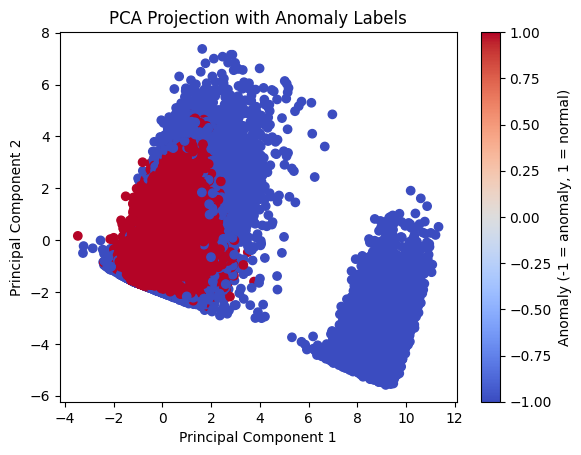

In [60]:
from sklearn.decomposition import PCA
pca=PCA(n_components=4)
features_pca=pca.fit_transform(features_scaled)
final["PC1"]= features_pca[:, 0]
final["PC2"]= features_pca[:, 1]

# Scatter plot 
plt.scatter(final["PC1"], final["PC2"], c=final["tree_anomaly_if"], cmap="coolwarm")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection with Anomaly Labels")
plt.colorbar(label="Anomaly (-1 = anomaly, 1 = normal)")
plt.show()


# interpretation
distinct distance between red(anomaly) and blue cluster (normal); 

some red are away from others, maybe true anomaly?



In [62]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", sum(pca.explained_variance_ratio_))
# first 2 only explain 61% of varaince, with 4 that's 90%

Explained variance ratio: [0.33423541 0.2779752  0.16666417 0.16628199]
Cumulative explained variance: 0.9451567843370098
